# **Fine-Grained Food Image Classification using Transfer Learning**

### Downloading and Storing the Food-101 Dataset



In [2]:
import kagglehub
path = kagglehub.dataset_download("crybread/food101")

100%|██████████| 4.66G/4.66G [00:53<00:00, 94.4MB/s]

Extracting files...


In [3]:
print(path)

/root/.cache/kagglehub/datasets/crybread/food101/versions/1


### Importing Required Libraries

This cell imports the core PyTorch and TorchVision modules needed for dataset handling, transformations, and data loading.


In [4]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torch.utils.data import random_split


### Dataset Path and Image Preprocessing

- Sets the dataset directory and target image size.
- Defines ImageNet normalization values for stable model training.
- Applies data augmentation and normalization for training images.
- Loads the Food-101 images using `ImageFolder` with the training transform.

On Colab, Drive-mounted datasets dominate runtime.
Copying to /content matters more than batch size or workers.

In [5]:

# DATA_DIR = "/content/food-101/images"
DATA_DIR = "/root/.cache/kagglehub/datasets/crybread/food101/versions/1/food-101/images"

imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform =  T.Compose([T.Resize((224,224)),
                              T.Pad(8, padding_mode='reflect'),
                              T.RandomCrop(224),
                              T.ToTensor(),
                              T.Normalize(*imagenet_stats)])
val_transform = T.Compose([T.Resize((224,224)),
                           T.ToTensor(),
                           T.Normalize(*imagenet_stats)])

dataset = datasets.ImageFolder(
    root=DATA_DIR,
    transform=train_transform
)


In [6]:
len(dataset)

101000

### Train–Validation Split

- Splits the dataset into training and validation sets using an 80:20 ratio.
- Uses random sampling to ensure unbiased data distribution.
- Applies separate preprocessing steps for validation data.


In [7]:
# Train / validation split (80/20)
val_pct = 0.2
val_size = int(val_pct * len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])

# Apply validation transforms
valid_ds.dataset.transform = val_transform

In [8]:
len(train_ds), len(valid_ds)

(80800, 20200)

### Utility Functions for Image Visualization

- Imports required libraries for tensor handling and plotting.
- Defines a helper function to reverse image normalization.
- Adds a utility to display sample images along with their class labels.


In [9]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label: ',dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1,2,0))
    plt.imshow(img_tensor)

Label:  baby_back_ribs (1)


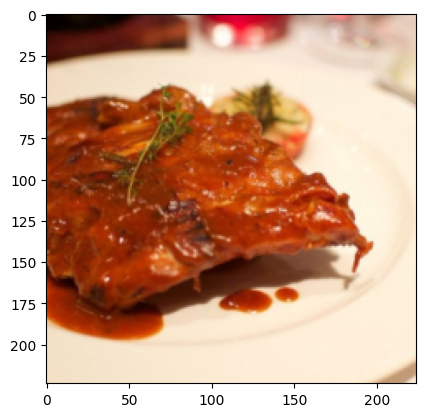

In [10]:
show_image(*dataset[1000])

### DataLoader Configuration

- Creates DataLoaders for training and validation datasets.
- Uses shuffling for training to improve generalization.
- Extracts class names and computes the total number of classes.


In [12]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2,  pin_memory=True)

class_names = dataset.classes
num_classes = len(class_names)

print(num_classes)

101


### Visualizing a Batch of Images

- Fetches a single batch from the DataLoader.
- Reverses normalization to make images human-readable.
- Arranges multiple images into a grid for quick inspection.



In [11]:
from torchvision.utils import make_grid

def show_batch(dl):
    images, labels = next(iter(dl))

    # Take first 64 images
    images = images[:64]

    # Denormalize
    images = images.cpu()
    images = denormalize(images, *imagenet_stats)

    # Clamp values to valid range
    images = images.clamp(0, 1)

    # Make grid
    grid = make_grid(images, nrow=8)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


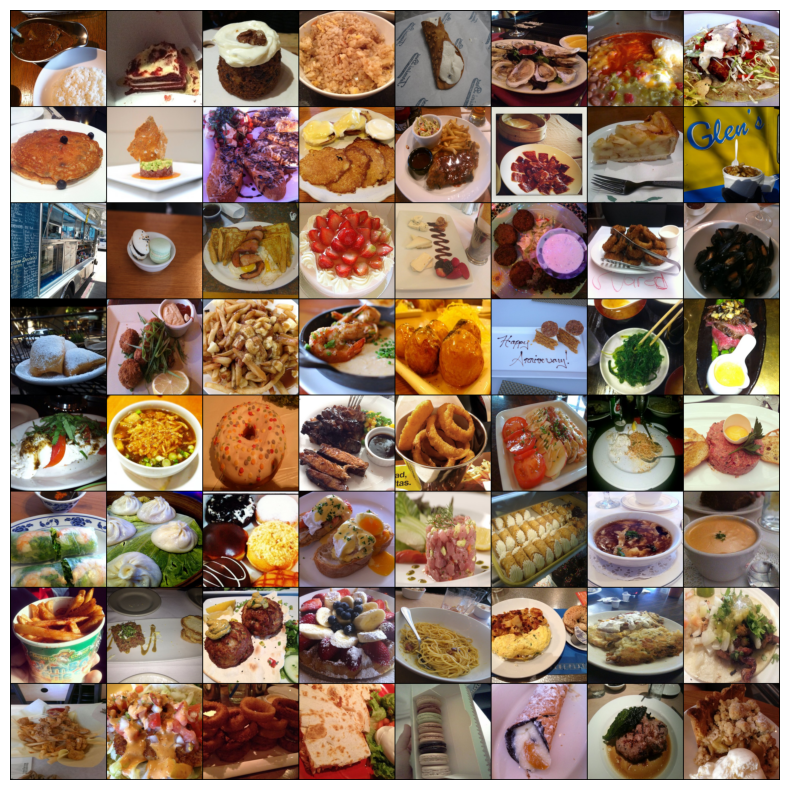

In [13]:
show_batch(train_dl)

### Training and Evaluation Utilities

- Defines a helper function to compute classification accuracy.
- Implements a base class to standardize training and validation steps.
- Tracks loss and accuracy at both batch and epoch levels.
- Provides a clean logging format for monitoring model performance.


In [14]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return (preds == labels).float().mean()

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                      # Generate Predictions
        loss = F.cross_entropy(out, labels)     # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                      # Generate Predictions
        loss = F.cross_entropy(out, labels)     # Calculate loss
        acc = accuracy(out, labels)             # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc':acc}

    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc =  torch.stack(batch_accs).mean()         # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        if 'lrs' in result:
            print(
                f"Epoch [{epoch}], last_lr: {result['lrs'][-1]:.5f}, "
                f"train_loss: {result['train_loss']:.4f}, "
                f"val_loss: {result['val_loss']:.4f}, "
                f"val_acc: {result['val_acc']:.4f}"
            )
        else:
            print(
                f"Epoch [{epoch}], "
                f"train_loss: {result['train_loss']:.4f}, "
                f"val_loss: {result['val_loss']:.4f}, "
                f"val_acc: {result['val_acc']:.4f}"
            )


## Stage 1: Frozen Backbone Transfer Learning

### Model Architecture (Transfer Learning)

- Uses a pretrained ResNet-18 model as the feature extractor.
- Freezes all convolutional backbone layers to preserve learned visual representations.
- Replaces the final fully connected classification layer to match the 101 Food-101 classes.
- Leverages transfer learning to reduce training time and improve convergence on limited training epochs.


Freezing means keeping pretrained layers fixed so only task-specific layers are updated during training.

### Loading Pretrained ResNet Weights

This cell loads the default ImageNet-trained weights for ResNet-18 to initialize the model with pretrained features.


In [19]:
from torchvision import models
weights = models.ResNet18_Weights.DEFAULT
resnet = models.resnet18(weights=weights)

class Food101Model(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a Pretrained Model
        self.network = resnet
        # Freeze backbone
        for param in self.network.parameters():
            param.requires_grad = False
        # Replace Last Layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


### GPU Tools and Utilities

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

### Training and Learning Rate Scheduling

- Defines evaluation logic without gradient computation.
- Implements a standard training loop with loss backpropagation.
- Adds One-Cycle Learning Rate scheduling for faster and stable convergence.
- Supports weight decay and gradient clipping for better training control.


In [16]:
import torch
from tqdm.auto import tqdm
import torch.nn.functional as F

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(filter(lambda p: p.requires_grad, model.parameters()),lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation Phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(filter(lambda p: p.requires_grad, model.parameters()), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation Phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history


In [17]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


In [ ]:
model = Food101Model(num_classes=num_classes)
to_device(model, device)

history = [evaluate(model, valid_dl)]
history

[{'val_loss': 4.851582050323486, 'val_acc': 0.010948071256279945}]

### Model Training

- Defines key training hyperparameters such as epochs and learning rate.
- Trains the model using the One-Cycle policy with Adam optimizer.
- Stores training history for later analysis and visualization.


I used Adam for faster convergence during frozen-backbone training, then compared it with SGD during fine-tuning.

In [ ]:
epochs = 5
max_lr = 1e-3
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00076, train_loss: 3.8738, val_loss: 2.7175, val_acc: 0.3947
Epoch [1], last_lr: 0.00095, train_loss: 2.3040, val_loss: 2.0816, val_acc: 0.4963
Epoch [2], last_lr: 0.00061, train_loss: 1.9902, val_loss: 1.9885, val_acc: 0.5110
Epoch [3], last_lr: 0.00019, train_loss: 1.8749, val_loss: 1.9317, val_acc: 0.5271
Epoch [4], last_lr: 0.00000, train_loss: 1.8159, val_loss: 1.9185, val_acc: 0.5303


- **Baseline**: Frozen ResNet-18 + Adam + OneCycleLR → ~53% val accuracy on Food-101 (5 epochs, ~38m)

## **Stage 2: Partial Fine-Tuning (Unfreezing High-Level Features)**

### Model Architecture and Training Strategy

- Builds upon the pretrained ResNet-18 backbone initialized in Stage 1.
- Freezes early and mid-level convolutional layers to retain generic visual features.
- Unfreezes the final residual block (layer4) to enable task-specific feature adaptation.
- Maintains the same classification head introduced in the baseline stage.
- Fine-tunes the model using the Adam optimizer with a reduced learning rate schedule.
- Continues to use OneCycleLR to ensure stable optimization during selective unfreezing.

This stage aims to balance representational flexibility and training stability by allowing higher-level semantic features to adapt to fine-grained food categories while preserving robust low-level visual patterns learned from ImageNet.


In [20]:
weights = models.ResNet18_Weights.DEFAULT
resnet = models.resnet18(weights=weights)

class Food101Model(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()

        # Instantiate pretrained ResNet-18
        self.network = resnet

        # Freeze entire backbone
        for param in self.network.parameters():
            param.requires_grad = False

        # Unfreeze last residual block (Stage 2)
        for param in self.network.layer4.parameters():
            param.requires_grad = True

        # Replace final classification layer
        self.network.fc = nn.Linear(
            self.network.fc.in_features,
            num_classes
        )

    def forward(self, xb):
        return self.network(xb)


In [21]:
def set_bn_eval(m):
    if isinstance(m, nn.BatchNorm2d):
        m.eval()


device = get_default_device()
device

device(type='cuda')

In [22]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2,  pin_memory=True)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


In [23]:
model = Food101Model(num_classes=num_classes)
to_device(model, device)
model.apply(set_bn_eval)


history_stage2 = [evaluate(model, valid_dl)]
history_stage2

Food101Model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [24]:
epochs = 10
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history_stage2  += fit_one_cycle(epochs, max_lr, model, train_dl,
                                 valid_dl, weight_decay, grad_clip, opt_func=opt_func)

Epoch [0], last_lr: 0.00003, train_loss: 3.9064, val_loss: 2.6639, val_acc: 0.4533
Epoch [1], last_lr: 0.00008, train_loss: 1.9529, val_loss: 1.5318, val_acc: 0.6292
Epoch [2], last_lr: 0.00010, train_loss: 1.2823, val_loss: 1.3256, val_acc: 0.6663
Epoch [3], last_lr: 0.00010, train_loss: 0.9862, val_loss: 1.2808, val_acc: 0.6744
Epoch [4], last_lr: 0.00008, train_loss: 0.7592, val_loss: 1.2888, val_acc: 0.6745
Epoch [5], last_lr: 0.00006, train_loss: 0.5467, val_loss: 1.2677, val_acc: 0.6829
Epoch [6], last_lr: 0.00004, train_loss: 0.3398, val_loss: 1.2656, val_acc: 0.6926
Epoch [7], last_lr: 0.00002, train_loss: 0.1755, val_loss: 1.2703, val_acc: 0.6999
Epoch [8], last_lr: 0.00000, train_loss: 0.0809, val_loss: 1.2624, val_acc: 0.7041
Epoch [9], last_lr: 0.00000, train_loss: 0.0464, val_loss: 1.2711, val_acc: 0.7057


**Stage 2**: Partial fine-tuning of ResNet-18 by unfreezing the final residual block (layer4), trained using Adam optimizer with OneCycleLR scheduling. To ensure stable optimization, gradient clipping (max norm = 0.1) and weight decay (1e−4) were applied. Batch normalization layers were kept in evaluation mode to preserve pretrained statistics. This setup achieved 70.57% validation accuracy on Food-101 after 10 epochs (~1h 10m).

**The strong performance achieved by unfreezing only the final residual block suggests that higher-level semantic adaptation plays a critical role in fine-grained food classification. Consequently, later stages focus on model reliability and decision confidence rather than deeper architectural modifications.**

### Optimizer Choice

Adam was selected as the primary optimizer across all training stages due to its adaptive learning rate mechanism, which enables faster and more stable convergence when fine-tuning pretrained networks. In the partial fine-tuning regime, where only a limited subset of parameters is updated and training is performed under a constrained epoch budget, Adam consistently provided more reliable early convergence behavior than SGD. While SGD is often preferred for long training schedules and final performance refinement, Adam was better aligned with the staged transfer learning strategy adopted in this work.


In [ ]:
torch.save(model.state_dict(), "stage2_resnet18.pth")

In [25]:
model.load_state_dict(torch.load("/content/stage2_resnet18.pth", map_location=device))

<All keys matched successfully>

# **Stage 3: Uncertainty-Aware and Confidence-Based Inference**

While Stage 2 established strong discriminative performance through partial fine-tuning, further improvements in raw accuracy were not the primary objective. Instead, Stage 3 focuses on enhancing the reliability of model predictions by explicitly modeling uncertainty. To this end, Monte Carlo Dropout is employed at inference time to estimate predictive uncertainty, enabling confidence-aware evaluation. Predictions with insufficient confidence are treated as ambiguous and handled separately, allowing the system to defer decisions rather than forcing potentially unreliable classifications.

**Step 1**: Enabling Uncertainty Estimation via MC Dropout

In [26]:
def enable_mc_dropout(m):
    if isinstance(m, nn.Dropout):
        m.train()

In [27]:
model.eval()                  # base eval
model.apply(set_bn_eval)      # keep BN frozen
model.apply(enable_mc_dropout)  # activate dropout randomness


Food101Model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [28]:
@torch.no_grad()
def mc_dropout_predict(model, images, T=20):
    probs = []

    for _ in range(T):
        outputs = model(images)
        p = F.softmax(outputs, dim=1)
        probs.append(p)

    probs = torch.stack(probs)        # [T, B, C]
    mean_probs = probs.mean(dim=0)    # [B, C]
    uncertainty = probs.var(dim=0).mean(dim=1)  # [B]

    return mean_probs, uncertainty

**Step 2**: Monte Carlo Dropout–based Confidence and Uncertainty Estimation

In [32]:
all_conf = []
all_unc = []
all_labels = []
all_preds = []


for images, labels in valid_dl:

    mean_probs, uncertainty = mc_dropout_predict(model, images, T=50)
    confidence, preds = mean_probs.max(dim=1)

    all_conf.append(confidence.cpu())
    all_unc.append(uncertainty.cpu())
    all_labels.append(labels.cpu())
    all_preds.append(preds.cpu())


all_conf = torch.cat(all_conf)
all_unc = torch.cat(all_unc)
all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)



**Step 3**: Confidence-Aware Decision Rules (Accept / Defer)

In [33]:
CONF_THRESHOLD = 0.6
UNC_THRESHOLD = all_unc.mean() + all_unc.std()

is_ambiguous = (all_conf < CONF_THRESHOLD) | (all_unc > UNC_THRESHOLD)


In [34]:
accepted_mask = ~is_ambiguous

coverage = accepted_mask.float().mean().item()

accepted_acc = (
    (all_preds[accepted_mask] == all_labels[accepted_mask])
    .float()
    .mean()
    .item()
)

defer_rate = 1.0 - coverage



In [35]:
print(f"Coverage: {coverage:.3f}")
print(f"Defer rate: {defer_rate:.3f}")
print(f"Accuracy on accepted samples: {accepted_acc:.3f}")


Coverage: 0.919
Defer rate: 0.081
Accuracy on accepted samples: 0.988


**STEP 4**— Threshold Sweeping

In [38]:
import numpy as np

conf_thresholds = np.linspace(0.3, 0.9, 13)

results = []

for ct in conf_thresholds:
    is_ambiguous = (all_conf < ct) | (all_unc > UNC_THRESHOLD)

    accepted = ~is_ambiguous
    coverage = accepted.float().mean().item()

    if accepted.sum() > 0:
        acc = (
            (all_preds[accepted] == all_labels[accepted])
            .float()
            .mean()
            .item()
        )
    else:
        acc = float("nan")

    results.append((ct, coverage, acc))


In [45]:
import pandas as pd

df = pd.DataFrame(
    results,
    columns=["Confidence Threshold", "Coverage", "Accepted Accuracy"]
)

df

,Confidence Threshold,Coverage,Accepted Accuracy
0,0.30,0.953713,0.973112
1,0.35,0.946980,0.976110
2,0.40,0.940297,0.979151
3,0.45,0.934604,0.981779
4,0.50,0.930248,0.983662
5,0.55,0.923911,0.986069
6,0.60,0.919059,0.988204
7,0.65,0.914604,0.989120
8,0.70,0.909554,0.990747
9,0.75,0.903614,0.992494


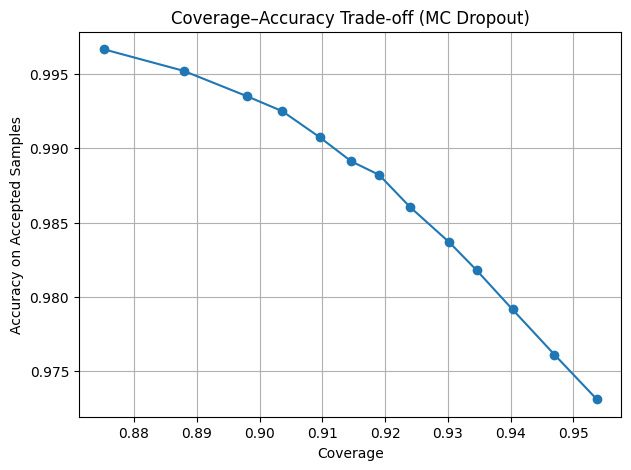

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(df["Coverage"], df["Accepted Accuracy"], marker="o")
plt.xlabel("Coverage")
plt.ylabel("Accuracy on Accepted Samples")
plt.title("Coverage–Accuracy Trade-off (MC Dropout)")
plt.grid(True)
plt.show()


**Each point represents a different confidence threshold.
As the model becomes more selective, accuracy increases while coverage decreases.**  

# **Stage 3 Results.**
This stage evaluates the reliability of the partially fine-tuned model using uncertainty-aware inference. Monte Carlo Dropout was employed at inference time to estimate predictive uncertainty, enabling confidence-based deferral of ambiguous samples. Rather than optimizing raw accuracy, evaluation focuses on selective performance metrics that jointly capture prediction reliability and coverage.

**Threshold Selection.**

The confidence threshold was selected based on the coverage–accuracy trade-off observed on the validation set. A threshold of 0.6 was chosen as it provides a balanced operating point, achieving high predictive reliability while maintaining broad coverage. This threshold was fixed for all subsequent evaluations.

**Selective Prediction Performance.**

At the selected confidence threshold, the model achieves an accuracy of 98.8% on accepted predictions, while maintaining 91.9% coverage, with 8.1% of samples deferred due to low confidence or high uncertainty.

| Metric            | Value     |
| ----------------- | --------- |
| Accepted accuracy | **98.8%** |
| Coverage          | **91.9%** |
| Defer rate        | **8.1%**  |


**Comparison with Forced Prediction.**

Under the standard forced prediction setting used in Stage 2, the model achieves 70.6% validation accuracy when required to predict on all samples. In contrast, the uncertainty-aware approach introduced in Stage 3 allows the model to abstain from ambiguous cases, resulting in substantially higher accuracy on accepted predictions at the cost of reduced coverage.

These results demonstrate that a significant portion of prediction errors originate from a relatively small subset of ambiguous samples. By explicitly identifying and deferring such cases, the model achieves markedly higher reliability on confident predictions without aggressive architectural changes. This highlights the practical value of uncertainty-aware inference for real-world deployment, where abstention is often preferable to overconfident misclassification.

# **Final Summary: Performance Across Stages**

| Stage       | Setup                                            | Accuracy   | Coverage  | Defer Rate | Key Objective                |
| ----------- | ------------------------------------------------ | ---------- | --------- | ---------- | ---------------------------- |
| **Stage 1** | Frozen ResNet-18 (ImageNet pretrained)           | **~53%**        | 100%      | 0%         | Baseline sanity check        |
| **Stage 2** | Partial fine-tuning (layer4) + Adam + OneCycleLR | **70.6%**  | 100%      | 0%         | Learn task-specific features |
| **Stage 3** | MC Dropout + confidence-based deferral (τ = 0.6) | **98.8%*** | **91.9%** | **8.1%**   | Reliability-aware inference  |


# **Conclusion**

This work presents a staged approach to fine-grained food image classification using a pretrained ResNet-18 model, progressing from baseline evaluation to reliability-aware inference. Initial experiments with a frozen backbone established a sanity-check baseline, while partial fine-tuning of higher-level layers enabled effective adaptation to the Food-101 dataset, achieving a validation accuracy of approximately 70.6%. These results confirmed that task-specific semantic features can be learned without aggressive architectural modifications.

Beyond accuracy optimization, the final stage of this project emphasized prediction reliability and decision confidence. By incorporating Monte Carlo Dropout at inference time, the model was able to estimate predictive uncertainty and selectively defer ambiguous samples. This confidence-aware inference strategy resulted in a substantial improvement in reliability, achieving 98.8% accuracy on accepted predictions while maintaining 91.9% coverage, with only 8.1% of samples deferred. These findings highlight that a significant portion of errors originates from a relatively small subset of uncertain inputs, and that explicitly handling such cases can markedly improve trustworthiness without retraining or increasing model complexity.

Overall, this study demonstrates that uncertainty-aware decision-making is a powerful complement to standard deep learning pipelines. Rather than treating all predictions equally, selectively deferring low-confidence cases enables a more deployment-ready system, particularly in scenarios where incorrect predictions carry higher costs than abstention. The staged methodology adopted in this work provides a practical framework for balancing performance, efficiency, and reliability, and can be readily extended to other vision tasks and real-world applications where trustworthy predictions are critical.